# Split satellite image into small pieces for model prediction

*Written by: Men Vuthy, 2022*

---


You can also run the code here in Google Colab. Try clicking button below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1a_SkW3HoAKP-dUNFQTyhhlL6j3Y0AmUg#scrollTo=5OyNzz48aOIg)

Predicting an image normally consume a lot of memory. If a whole image is used for model prediction, the runtime will cut off and it might affect the result of prediction too. Therefore, by splitting the image into small pieces, it usually improve the runtime and result.

### Objective

*   Split WV-3 satellite images into small pieces with the shape less than (2000, 2000, 3) based on the grid geometry.



### Code

**Install modules and import all necessary datasets**

In [1]:
!pip install rasterio
!pip install geopandas

In [2]:
import os
import glob
import rasterio
import geopandas as gpd
import fiona
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
%matplotlib inline

**Import dataset from Kaggle**

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d menvuthy/pretrained-model-for-building-footprint-extraction
!unzip pretrained-model-for-building-footprint-extraction

pretrained-model-for-building-footprint-extraction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pretrained-model-for-building-footprint-extraction.zip
replace best_model.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: best_model.pth          
  inflating: reference.txt           


In [5]:
!kaggle datasets download -d menvuthy/sample-wv3-image
!unzip sample-wv3-image

sample-wv3-image.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sample-wv3-image.zip
replace sample_wv3/Grid.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_wv3/Grid.cpg     
  inflating: sample_wv3/Grid.dbf     
  inflating: sample_wv3/Grid.prj     
  inflating: sample_wv3/Grid.shp     
  inflating: sample_wv3/Grid.shx     
  inflating: sample_wv3/WV3_P001.TIF  


**Read input image**

In [6]:
# Import raster file from directory
image = rasterio.open('/content/sample_wv3/WV3_P001.TIF')

In [7]:
# The original shape of image before splitting
print(image.read(1).shape)

(7924, 19442)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


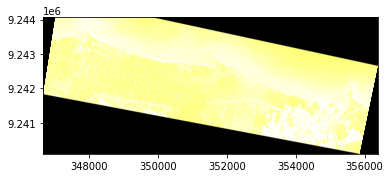

In [8]:
# Visualize image
show(image)

**Read grid shape**

This grid can be easily done in QGIS using `Create Grid...` in Research Tool in Vector.

In [9]:
# Import grid file from directory
grid_geo = gpd.read_file('/content/sample_wv3/Grid.shp')
grid_geo.head()

,id,left,top,right,bottom,geometry
0,1.0,346657.5,9244064.5,348157.5,9242564.5,"POLYGON ((346657.500 9244064.500, 348157.500 9..."
1,2.0,346657.5,9242564.5,348157.5,9241064.5,"POLYGON ((346657.500 9242564.500, 348157.500 9..."
2,3.0,346657.5,9241064.5,348157.5,9239564.5,"POLYGON ((346657.500 9241064.500, 348157.500 9..."
3,4.0,348157.5,9244064.5,349657.5,9242564.5,"POLYGON ((348157.500 9244064.500, 349657.500 9..."
4,5.0,348157.5,9242564.5,349657.5,9241064.5,"POLYGON ((348157.500 9242564.500, 349657.500 9..."


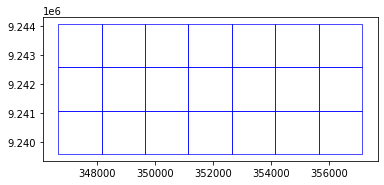

In [10]:
# Plot the grid shape
grid_geo['geometry'].plot(facecolor="none", edgecolor='blue', lw=0.7);

**Mask main image into 21 images**

From the grid, there are in total of 21 squares, which means I will mask the raster image into 21 images based on the square size.

In [11]:
# Read Shape file
with fiona.open('/content/sample_wv3/Grid.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

Mask the raster image one by one into 21 images using loop operation

In [12]:
# Create an empty list for clipped result
Out_img , Out_transform = [], []

for i in range(len(shapes)):
  # Extract shape
  shape = [shapes[i]]
  
  # Mask the raster with Polygon
  out_img, out_transform = mask(image, shape, crop=True)

  # Append to list
  Out_img.append(out_img)
  Out_transform.append(out_transform)


Visualize sample output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


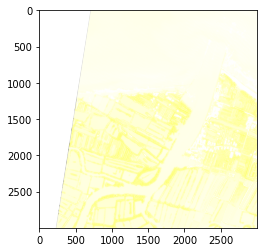

In [13]:
show(Out_img[0])

**Export result**

In [14]:
# Create file name number for each result
order = [str(x) for x in range(1, len(shapes) +1)]

Export masked images to output directory 

In [15]:
for i in range(len(shapes)):
  # Data dir
  data_dir = "/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/output/wv3-images"

  # Output raster
  out_tif = os.path.join(data_dir, 'image0'+ order[i] +'.tiff')

  # Copy the metadata
  out_meta = image.meta.copy()

  # Update meta
  out_meta.update({"driver": "GTiff",
                  "dtype": 'uint16',
                  "height": Out_img[i].shape[1],
                  "width": Out_img[i].shape[2],
                  "transform": Out_transform[i],
                  "count": 4,
                  "crs": image.crs})

  # Write image
  with rasterio.open(out_tif, "w", **out_meta) as dest:
          dest.write(Out_img[i].astype('uint16'))


Finally, we can see how to split satellite image into small pieces for model prediction. 

---

